<a href="https://colab.research.google.com/github/martinoywa/zindi-challenges/blob/main/Road%20Segment%20Identification/PyTorch_FineTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Files



*   Download Image files
*   Upload Test and Train csv metadata files



In [3]:
import requests
import requests, zipfile


url = "https://api.zindi.africa/v1/competitions/road-segment-identification/files/Images.zip"
token = {"auth_token":"1KJ4bWkMiaWnz2RWgNnjNVtZ"}

x = requests.post(url, data = token,stream=True)
target_path = 'Images.zip'

handle = open(target_path, "wb")
for chunk in x.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

!unzip -qq /content/Images.zip


In [10]:
# create data folders
import os


os.makedirs("data/train/0")
os.makedirs("data/train/1")
os.makedirs("data/test/test")

In [5]:
import torch
import torch.nn as nn
import torchvision

import pandas as pd
import shutil
import matplotlib.pylab as plt
import numpy as np

# Dataset Splitting

- Copy all train data to the train folders
- Copy all test data to the test folder

In [7]:
train_data = pd.read_csv("Train.csv")
train_data.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


In [8]:
files = []
for (root, dirs, file ) in os.walk("Images"):
    files += file

In [11]:
# copy to data
image_ids = train_data["Image_ID"].values
for i in range(len(files)):
    if files[i][:-4] in image_ids:
        shutil.copy("Images/"+files[i], "data/train/"+str(train_data.loc[train_data["Image_ID"] == files[i][:-4]]["Target"].values[0]))

In [12]:
test_data = pd.read_csv("Test.csv")
# copy to data
image_ids_test = test_data["Image_ID"].values
for i in range(len(files)):
    if files[i][:-4] in image_ids_test:
        shutil.copy("Images/"+files[i], "data/test/test")

# Data Loaders

In [13]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.ImageFolder("data/train/", transform=transform)
testset = torchvision.datasets.ImageFolder("data/test/", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=32)

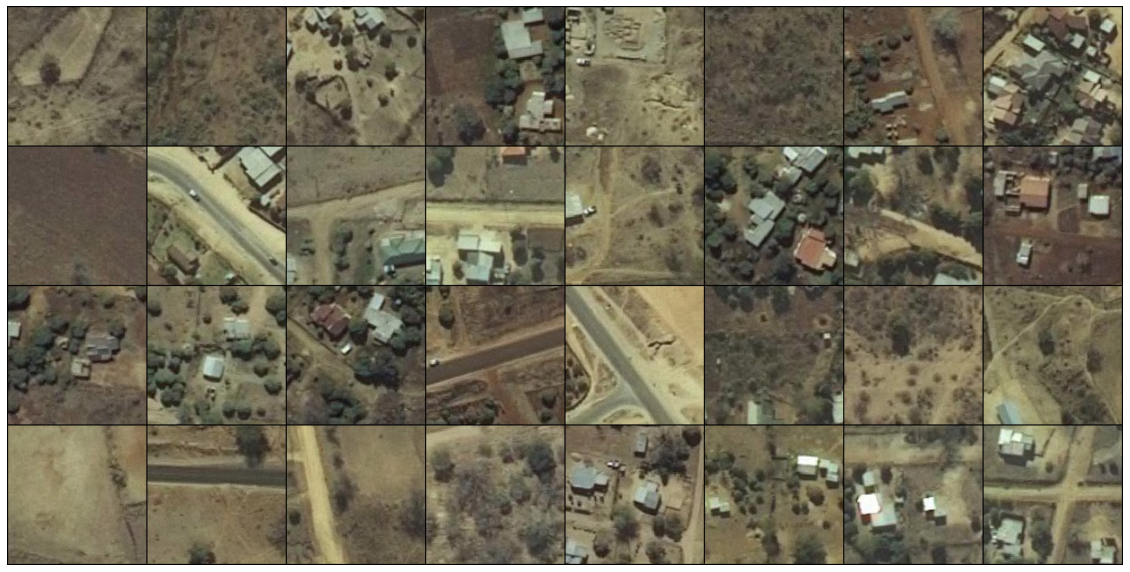

tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1])


In [14]:
# visualize
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
plt.figure(figsize=(20, 20))
plt.axis('off')
imshow(torchvision.utils.make_grid(images))
print(labels)

# Model Finetuning

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
%%capture
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
epochs = 2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01)

In [19]:
for epoch in range(epochs):
    running_loss = 0
    for batch, (data, targets) in enumerate(trainloader, 1):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()*len(trainloader)

    print(f"Epoch: {epoch}, Train Loss: {running_loss/len(trainloader):.3f}")

Epoch: 0, Train Loss: 125.328
Epoch: 1, Train Loss: 111.419


# Submission

In [24]:
%%capture
model.to("cpu")

In [20]:
# load test data
test_data = pd.read_csv("Test.csv")

In [25]:
# add predictio to target column
for i in range(len(testset)):
    id = testset.imgs[i][0][15:-4]
    output = model(testset[i][0].unsqueeze(0))
    test_data.loc[test_data["Image_ID"] == id, "Target"] = float(output[0][1]) # we are interested in P(Target=1)

In [26]:
test_data

,Image_ID,Target
0,ID_01c6i2wd,0.703233
1,ID_03sPqBLY,0.708314
2,ID_06ZKUQFl,0.686255
3,ID_06gzqIwK,0.691950
4,ID_08kWat36,0.644085
...,...,...
2995,ID_zxBFKP2n,0.721518
2996,ID_zxN7nQbW,0.649507
2997,ID_zyWc0ENM,0.705410
2998,ID_zywRGuyq,0.737648


In [27]:
test_data.to_csv("submission_3.csv", index=False)